In [243]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 20)

In [2]:
df = pd.read_pickle('./RUSFULL_processed.pickle')

In [10]:
df['year'] = df['date'].dt.year

In [12]:
split2014 = df[df['year'] == 2014]

# Обучим модель по tfidf
По базовому году

In [20]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [24]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [162]:
russian_stopwords = russian_stopwords + ['год','который','свой','стать','новый','фото','дробный']

In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words = russian_stopwords,ngram_range=(1,2),max_features= 4000)

In [164]:
cv = tfidf_vec.fit_transform(split2014['text_norm'])

In [165]:
tfidf_df = pd.DataFrame(cv.A, columns = tfidf_vec.get_feature_names())

In [45]:
tfidf_df.shape[1]

4000

In [46]:
tfidf_df.iloc[:,1]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
46497    0.0
46498    0.0
46499    0.0
46500    0.0
46501    0.0
Name: абрам, Length: 46502, dtype: float64

In [166]:
import matplotlib.pyplot as plt

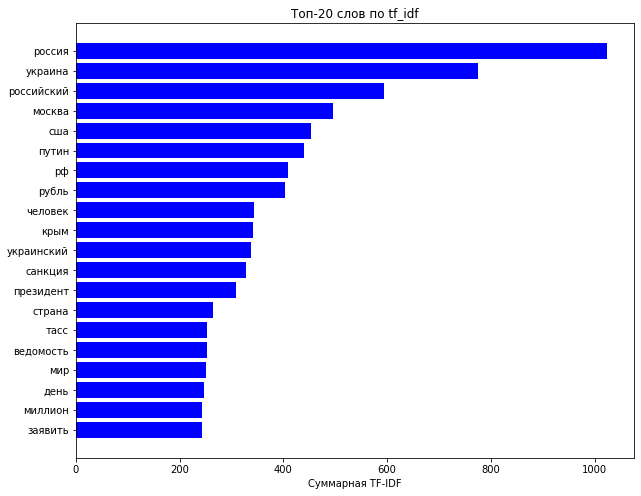

In [167]:
top_words = pd.DataFrame(
    {'words': tfidf_vec.get_feature_names(),
     'tf_idf': [sum(tfidf_df.iloc[:,i]) for i in range(tfidf_df.shape[1])]
    })
ttop = top_words.sort_values(by = ['tf_idf'], 
                             ascending=False).head(20).sort_values(by = ['tf_idf'], 
                                                                            ascending=True)

plt.figure(figsize=(10, 8))
plt.title('Топ-20 слов по tf_idf')
plt.barh(ttop['words'],
         ttop['tf_idf'], color='b', align='center')
plt.xlabel('Суммарная TF-IDF')
plt.show()

In [50]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [66]:
lda = LatentDirichletAllocation()

In [67]:
params = {'n_components':np.arange(10,81,5)}

In [68]:
grid = GridSearchCV(lda,params)

In [73]:
cv.shape

(46502, 4000)

In [76]:
46502/1000*3/60

2.3251

In [87]:
%%time
grid.fit(cv[:15000])

Wall time: 48min 41s


GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [234]:
model = LatentDirichletAllocation(n_components = 45)
model.fit(cv)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=45, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [235]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}: ".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

n_top_words = 20

print("\nTopics в модели LDA: ")

# Получаем топики
tf_feature_names = tfidf_vec.get_feature_names()
print_top_words(model, tf_feature_names, n_top_words)


Topics в модели LDA: 

Topic #0: цена нефть россия рынок поставка цена нефть рост падение продукт зоопарк газа продукция мясо баррель добыча снижение сноуден рост цена производитель российский

Topic #1: миллиард миллиард рубль москва рубль ожидаться дорогой иск столичный платный эвакуировать выделить согласиться почта градус лечение снег украинец потратить спикер жара

Topic #2: турист ростовский учёный ростовский область край турция область уникальный новогодний свет новое санкция девочка рыба селфи вооружение найти признаться хит сократиться российский турист

Topic #3: чёрный поток фильм южный поток обвинять мор оскар южный хороший канал наградить суд пустить прокурор победитель актриса госпитализировать убийство признанный болгария

Topic #4: медведев нато украина россия дмитрий дмитрий медведев совет обсе пенсия оон наблюдатель предложить статус разрешение особый просьба обратиться поступить назначить рф

Topic #5: рубль доллар миллион курс евро миллион рубль тысяча рубль тысяча

In [159]:
split2014['text_norm'][split2014['text_norm'].str.contains('дробный')].sample(1)

18319    космолог вселенная должный прожить долгий секунда дробный
Name: text_norm, dtype: object

In [134]:
split2014 = split2014.reset_index()

In [161]:
split2014.loc[18319]['text']

'Космологи: Вселенная не должна была прожить дольше секунды.\n\nПодробнее: www.rg.ru/2014/06/25/vselennaya-anons.html'

In [176]:
model.transform()

array([[ 0.0666667 ,  0.06666672,  0.06666667, ...,  0.06666669,
         0.06666684,  0.06666668],
       [ 0.06666669,  0.06666668,  0.06666668, ..., 10.54037013,
         0.06666681,  0.06666667],
       [ 0.06666667,  0.06666667,  0.06666667, ...,  3.06829695,
         0.06666667,  0.06666668],
       ...,
       [ 0.06666673,  0.06666669,  0.06666668, ...,  0.06666671,
         0.39399193,  0.06666667],
       [ 0.06666669,  0.06666668,  0.06666668, ...,  1.0814993 ,
         0.06666667,  0.06666667],
       [ 0.0666667 ,  0.06666672,  0.06666668, ...,  0.06666959,
         0.06666678,  0.0666672 ]])

In [190]:
np.argmax(model.transform(cv),axis =1)

array([ 3, 13,  3, ...,  1,  9,  3], dtype=int64)

In [237]:
split2014['n_topic'] = np.argmax(model.transform(cv),axis =1)
split2014['topic_proba'] = np.max(model.transform(cv),axis =1)


In [218]:
with pd.option_context('display.max_colwidth', 9999):
    display(split2014[split2014['n_topic'] == 10].sort_values('topic_proba', ascending=False).head(5)['text'])

28180    Известная гимнастка и депутат «Единой России» Алина Кабаева согласилась возглавить совет директоров «Национальной медиа группы». http://vdmsti.ru/~hsZ Фото: Д.Гришкин/Ведомости\n\nВ холдинг входят РЕН-ТВ и «Пятый канал», газета «Известия» и «Русская служба новостей» (этими двумя СМИ управляет «Ньюз медиа» Арама Габрелянова). Также холдинг владеет блокпакетом «Первого канала» и контрольным пакетом Art Pictures Studio Федора Бондарчука и Дмитрия Рудовского.
22538                                                                                                                                                         Двукратный олимпийский чемпион Евгений Плющенко заявил, что в его планы не входил отказ от участия в соревнованиях. "Я все сделал для сборной, для страны. Для тех, кто в меня верил. Что делать, если на этот раз боль оказалась сильнее", - подчеркнул спортсмен.\n\nПодробнее: www.rg.ru/2014/02/13/borba-site.html
26992                                                         

In [227]:
split2014[split2014['n_topic'] == 3].sort_values('topic_proba', ascending=False).head(50)['source'].value_counts()

TASS         26
RBK          14
RG            6
VEDOMOSTI     4
Name: source, dtype: int64

In [230]:
from scipy.stats import chi2_contingency
chi2_contingency([[26, 14, 6, 4], 
                  [15131, 5814, 18227, 7330]])

(26.73399448186866,
 6.693869278747851e-06,
 3,
 array([[1.62796443e+01, 6.25966661e+00, 1.95834765e+01, 7.87721258e+00],
        [1.51407204e+04, 5.82174033e+03, 1.82134165e+04, 7.32612279e+03]]))

In [228]:
split2014['source'].value_counts()

RG           18227
TASS         15131
VEDOMOSTI     7330
RBK           5814
Name: source, dtype: int64

In [225]:
split2014[split2014['n_topic'] == 3].sort_values('topic_proba', ascending=False).head(10)

,index,date,text,source,text_norm,title,title_norm,year,n_topic,topic_proba
36002,126560,2014-09-11 05:53:01,"Президент Украины внесет соглашение об ассоциации с ЕС в Раду 16 сентября, сообщает Александр Ту...",TASS,президент украина внести соглашение ассоциация ес раду сентябрь сообщать александр турчин парлам...,NaN,NaN,2014.0,3,0.839528
39804,130362,2014-06-27 13:45:00,"Открыто производство по делу о легитимности назначения Яценюка премьер-министром, пишут украинск...",TASS,открыто производство дело легитимность назначение яценюк премьер министр писать украинский сми и...,NaN,NaN,2014.0,3,0.828038
38247,128805,2014-07-25 14:30:08,"Пушков назвал отставку Яценюка ""жестом отчаяния"". По мнению главы комитета Госдумы по международ...",TASS,пушок назвать отставка яценюк жест отчаяние мнение глава комитет госдума международный дело тако...,NaN,NaN,2014.0,3,0.827800
583,57048,2014-11-22 10:09:22,"Кудрин не исключил отставку правительства в ближайшее время. На вопрос о том, готов ли он стать ...",RBK,кудрин исключить отставка правительство ближний время вопрос готовый стать премьер министр экс г...,NaN,NaN,2014.0,3,0.823996
40671,131229,2014-06-09 06:42:38,"Саакашвили могут объявить в международный розыск. По данным СК РФ, экс-президент Грузии ""ставил ...",TASS,саакашвили мочь объявить международный розыск дать ск рф экс президент грузия ставить свой цель ...,NaN,NaN,2014.0,3,0.823177
39783,130341,2014-06-27 20:16:40,Правительство ДНР примет срочные меры по выходу из законодательного поля Украины в связи с подпи...,TASS,правительство днр принять срочный мера выход законодательный поль украина связь подписание согла...,NaN,NaN,2014.0,3,0.822813
45257,135815,2014-02-11 08:11:48,"""О полной отмене ""крепостного пенсионного права"" говорить, наверное, рановато. Мне более импонир...",TASS,полный отмена крепостной пенсионный право говорить наверное рановато импонировать возврат механи...,NaN,NaN,2014.0,3,0.820578
39836,130394,2014-06-27 06:40:00,"В Госдуму внесен законопроект, изменяющий положения Гражданского кодекса о наследстве. В случае ...",TASS,госдума внести законопроект изменять положение гражданский кодекс наследство случай принятие док...,NaN,NaN,2014.0,3,0.820282
32289,122847,2014-12-08 10:03:18,"Президентом России в Госдуму внесен законопроект, направленный на совершенствование уголовно-пра...",TASS,президент россия госдума внести законопроект направить совершенствование уголовно правовой механ...,NaN,NaN,2014.0,3,0.818614
2272,58737,2014-07-28 12:51:31,"Яценюк, которого Рада пока не отправила в отставку, решил вернуться к работе.\n\nОн призвал депу...",RBK,яценюк который рада пока отправить отставка решить вернуться работа призвать депутат принять неп...,NaN,NaN,2014.0,3,0.817131


In [288]:
topic_freq = split2014['n_topic'].value_counts()
topic_freq

0     3567
21    1933
6     1538
44    1532
5     1525
      ... 
20     713
13     680
33     637
15     534
14     428
Name: n_topic, Length: 45, dtype: int64

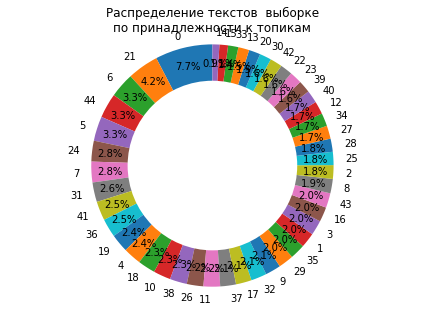

In [240]:
fig1, ax1 = plt.subplots()


 
ax1.pie(topic_freq.values, labels=topic_freq.index.tolist(), 
         autopct='%1.1f%%', startangle=90, pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Распределение текстов  выборке\nпо принадлежности к топикам')
plt.show()

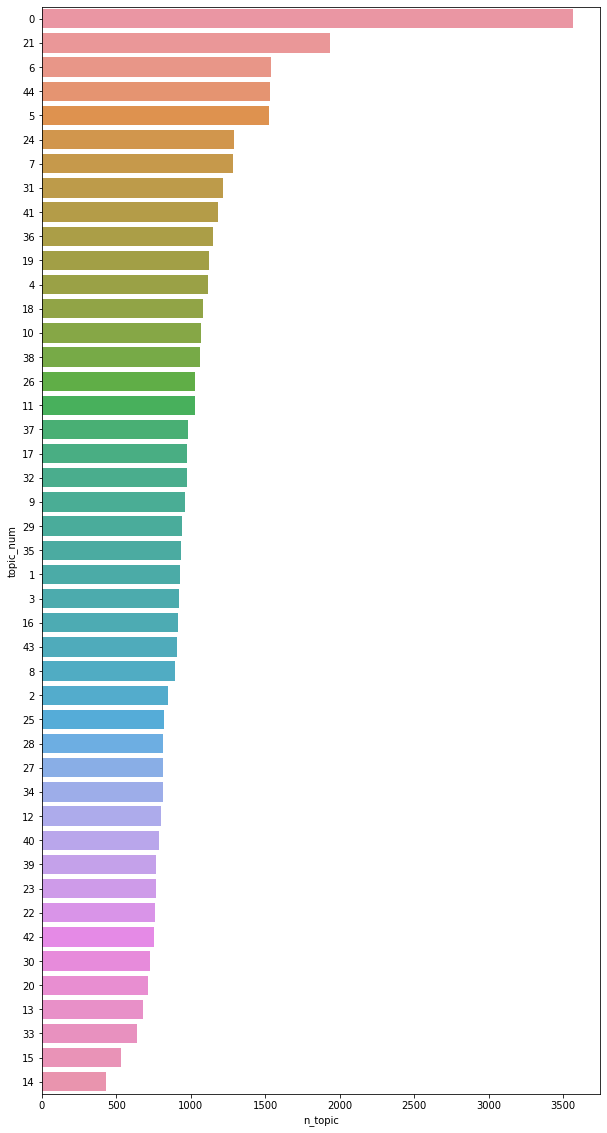

In [320]:
plt.figure(figsize=(10,20))
sns.barplot(y=freq['topic_num'],x='n_topic',data=freq,order = freq['topic_num'],orient = 'h')

In [274]:
topic_freq.index

Int64Index([ 0, 21,  6, 44,  5, 24,  7, 31, 41, 36, 19,  4, 18, 10, 38, 26, 11,
            37, 17, 32,  9, 29, 35,  1,  3, 16, 43,  8,  2, 25, 28, 27, 34, 12,
            40, 39, 23, 22, 42, 30, 20, 13, 33, 15, 14],
           dtype='int64')

# Проверим некоторые гипотезы о смещении распределения в изданиях

In [334]:
split2014['source'].value_counts()

RG           18227
TASS         15131
VEDOMOSTI     7330
RBK           5814
Name: source, dtype: int64

**Возьмем интересующие для гипотезы нас темы**

**Темы про Украину**

In [335]:
# Тема 27 - подтверждается 
from scipy.stats import chi2_contingency
chi2_contingency([[374,303,47,89], 
                  [18227, 15131, 7330, 5814]])

(67.50929086926217,
 1.4570065070421943e-14,
 3,
 array([[  319.61561873,   265.19797105,   126.75686357,   101.42954666],
        [18281.38438127, 15168.80202895,  7250.24313643,  5801.57045334]]))

In [336]:
split2014[split2014['n_topic'] == 28].sort_values('topic_proba', ascending=False)['source'].value_counts()

RG           289
TASS         282
RBK          131
VEDOMOSTI    112
Name: source, dtype: int64

In [337]:
# Тема 28 
from scipy.stats import chi2_contingency
chi2_contingency([[289,282,112,131], 
                  [18227, 15131, 7330, 5814]])

(14.126775802013816,
 0.002737570712920575,
 3,
 array([[  318.53969059,   265.15728295,   128.02832023,   102.27470623],
        [18197.46030941, 15147.84271705,  7313.97167977,  5842.72529377]]))

In [330]:
# На теме 8 подтверждается 
from scipy.stats import chi2_contingency
chi2_contingency([[233, 254, 251, 153], 
                  [18227, 15131, 7330, 5814]])

(141.8552319194132,
 1.504597422913782e-30,
 3,
 array([[  347.0525183 ,   289.24176566,   142.52465554,   112.18106049],
        [18112.9474817 , 15095.75823434,  7438.47534446,  5854.81893951]]))

In [254]:
import pyLDAvis
from pyLDAvis.sklearn import prepare as sklearn_prepare
pyLDAvis.enable_notebook()

sklearn_prepare(model, cv, tfidf_vec)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21    -0.140244 -0.128035       1        1  3.471909
44    -0.131443  0.056694       2        1  3.047397
6      0.181589  0.010808       3        1  3.044244
5      0.040177  0.246597       4        1  3.016178
0     -0.063740  0.216409       5        1  2.966324
...         ...       ...     ...      ...       ...
13     0.055946  0.045967      41        1  1.818756
30     0.030422  0.025743      42        1  1.812966
33    -0.110173  0.101966      43        1  1.723271
15     0.014571  0.046032      44        1  1.635637
14     0.123368  0.009980      45        1  1.484611

[45 rows x 5 columns], topic_info=                Term        Freq       Total Category  logprob  loglift
2989           рубль  369.000000  369.000000  Default  30.0000  30.0000
3038         санкция  306.000000  306.000000  Default  29.0000  29.0000
3805            цена  200.000000  200.000000  Default  28.0000  28.0000
806           доллар  158.000000  158.000000  Default  27.0000  27.0000
3466            тасс  238.000000  238.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
575   генпрокуратура   16.093270   29.853148  Topic45  -4.7547   3.5921
3539          трасса   15.931619   29.656025  Topic45  -4.7648   3.5887
3444            счёт   18.233935   87.514327  Topic45  -4.6298   2.6415
2958          россия   22.952734  987.460962  Topic45  -4.3996   0.4483
1610          минута   15.499375   38.138462  Topic45  -4.7923   3.3096

[2373 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
0        44  0.946377          абонент
1        25  0.988775            абрам
2        25  0.969086  абрам ведомость
3        21  0.841026          абхазия
3        34  0.044265          абхазия
...     ...       ...              ...
3997     32  0.055135           яценюк
3997     36  0.441077           яценюк
3998     24  0.886442             ящик
3998     33  0.110805             ящик
3999     33  0.912955             ёлка

[9887 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 45, 7, 6, 1, 8, 25, 32, 42, 20, 37, 19, 39, 5, 11, 38, 27, 18, 12, 9, 10, 44, 30, 4, 36, 2, 33, 17, 29, 26, 40, 35, 3, 43, 13, 41, 21, 23, 24, 28, 14, 31, 34, 16, 15])

In [350]:
split2014['date'] = split2014['date'].dt.date

In [364]:
split2014['date'] = pd.to_datetime(split2014['date'])

In [365]:
split2014['date'

0       2014-12-31
1       2014-12-31
2       2014-12-31
3       2014-12-31
4       2014-12-31
           ...    
46497   2014-01-01
46498   2014-01-01
46499   2014-01-01
46500   2014-01-01
46501   2014-01-01
Name: date, Length: 46502, dtype: datetime64[ns]

In [369]:
pd.get_dummies(split2014['n_topic']).set_index(split2014['date'])

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2014-12-31,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-01,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [378]:
split2014[split2014['date'] == '2014-01-01']['n_topic'].value_counts()

38    5
26    4
24    4
0     3
9     3
     ..
28    1
32    1
35    1
36    1
19    1
Name: n_topic, Length: 34, dtype: int64

In [371]:
time_series = pd.get_dummies(split2014['n_topic']).set_index(split2014['date']).resample('D').sum()

In [394]:
time_series

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,3,1,2,1,1,2,2,3,0,3,...,1,1,0,5,0,0,3,2,1,1
2014-01-02,2,1,2,2,1,3,5,1,0,3,...,2,0,1,0,0,1,0,6,0,0
2014-01-03,2,1,2,0,0,3,1,2,0,3,...,7,0,0,0,1,0,1,1,0,0
2014-01-04,3,0,1,0,3,0,1,1,1,2,...,6,0,0,0,1,4,1,4,0,1
2014-01-05,0,2,0,0,0,0,1,1,0,0,...,2,1,1,1,1,1,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-26,19,7,9,0,5,10,5,5,4,6,...,3,1,2,7,3,4,4,5,1,3
2014-12-27,6,3,1,1,4,5,1,2,3,0,...,2,3,0,4,3,0,0,1,2,1
2014-12-28,7,1,0,0,1,1,0,3,1,0,...,1,3,1,2,3,2,2,7,0,1


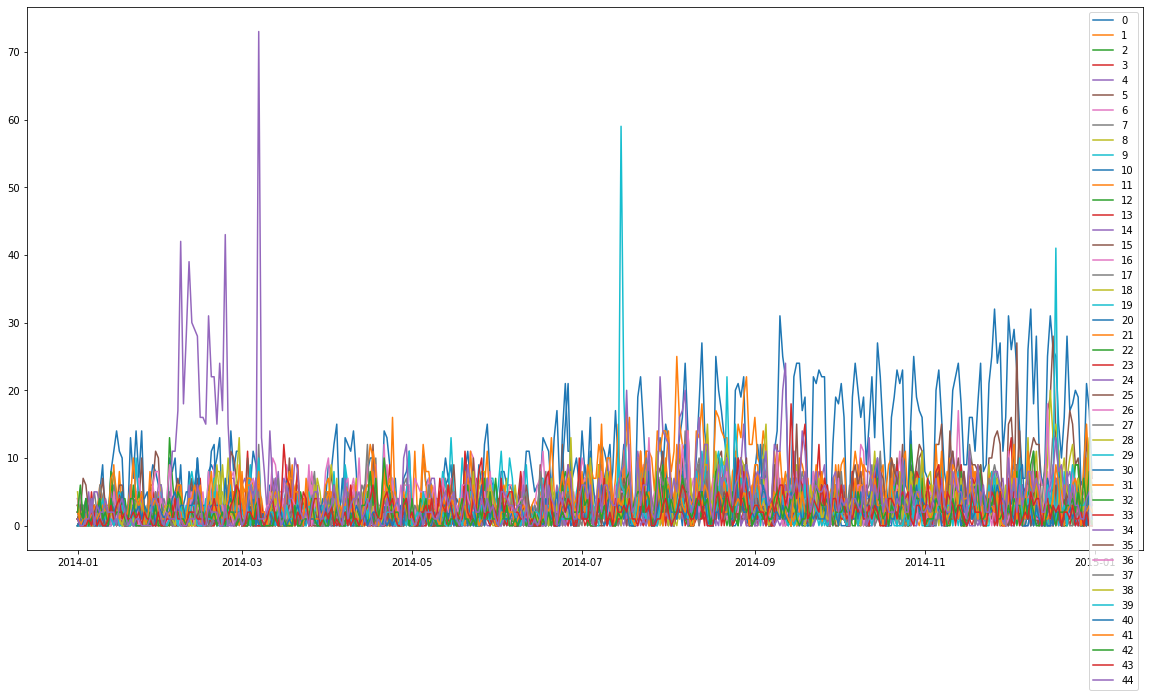

In [383]:
plt.figure(figsize = (20,10))
plt.plot(time_series)
plt.legend(labels = time_series.columns)

In [ ]:
! conda install -c plotly chart-studio

In [396]:
import plotly.graph_objs as go

In [ ]:

import plotly.graph_objs as go


traces = []
for i in range(5):
    traces.append(
    dict(
    x=time_series.index,
    y=time_series.iloc[:,i], 
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5,
              color=colors[i]),
    stackgroup='one')
    )

layout = go.Layout(
    title='Публикации  по топикам',
    legend=dict(orientation="h"),
    yaxis=dict(
        title='Количество в день'
    )
)    

fig = dict(data=traces, layout=layout)

py.iplot(fig, filename='stacked-area-plot-hover', validate=False)

In [355]:
result[['topic_0','topic_1','topic_2','topic_3','topic_4']] = pd.get_dummies(result['HigherTopic'])
result[['subtopic_0','subtopic_1','subtopic_2']] = pd.get_dummies(result['LowerTopic'])
result.tail()